In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Restart kernel after runnning this cell for the imports to take actions 
import sys
import torch

pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

!pip install -r requirements.txt
!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html
pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html


In [3]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference
from blockgen.utils.metrics import compute_metrics
from blockgen.utils.evaluate import evaluate_generation
from scripts.legolize import LegoConverter

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## Visualization

RGB range: [0.000, 0.949]
Alpha range: [0.000, 1.000]
Occupied voxels: 1380 (4.21% of volume)


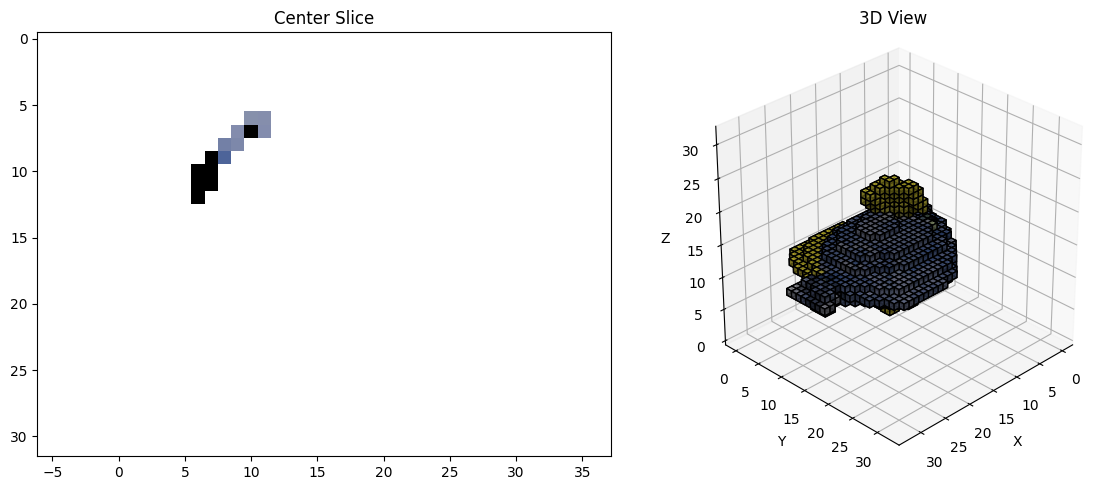

In [5]:
from blockgen.utils import plot_voxel_tensor
import matplotlib.pyplot as plt

plot_voxel_tensor(torch.load("evaluation_set_voxelized/sawyer_fish_001.pt"))

plt.show()

## Configs

In [5]:
# Configs for two_stage
shape_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='shape',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

color_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='color',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

shape_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42 
    )

color_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42 
    )

# Configs for Combined RGBA (Simple) 

combined_voxel_config_simple = VoxelConfig(
    mode='combined', 
    stage=None,  
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0,
    use_simple_mse=True
)

combined_diffusion_config_simple = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,  # Enable EMA
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    use_ddim=False, 
    seed=42 
)

# Configs for Combined RGBA (Weighted) 

combined_voxel_config_weighted = VoxelConfig(
    mode='combined', 
    stage=None,  
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0,
    use_simple_mse=False
)

combined_diffusion_config_weighted = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,  # Enable EMA
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    use_ddim=False, 
    seed=42 
)

## Training

In [ ]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=3
)

In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## Inference

In [10]:
# combined_model_simple = load_model_for_inference(
#         model_path="runs/experiment_color_simple_mse/models/model_step_60000",
#         voxel_config=combined_voxel_config_simple,
#         diffusion_config=combined_diffusion_config_simple,
#         device='cuda',
#         ema=False
#     )

# combined_model_weighted = load_model_for_inference(
#         model_path="runs/experiment_color_60k/models/model_step_60000",
#         voxel_config=combined_voxel_config_weighted,
#         diffusion_config=combined_diffusion_config_weighted,
#         device='cuda',
#         ema=False
#     )

shape_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/shape/best_model/model",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=False
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/best_model/model",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=False
    )

The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights


In [7]:
# Inference
inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Combined xor Shape only model

In [127]:
samples = inferencer.sample(
    prompt="A blue sphere",
    num_samples=1,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=20,
    use_mean_init=False,
    py3d=False,
    use_rotations=False
)


ampling Steps: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.70it/s]


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 4454 (13.59%)

Color Dominance:
Red: 29.7%
Green: 31.5%
Blue: 38.8%


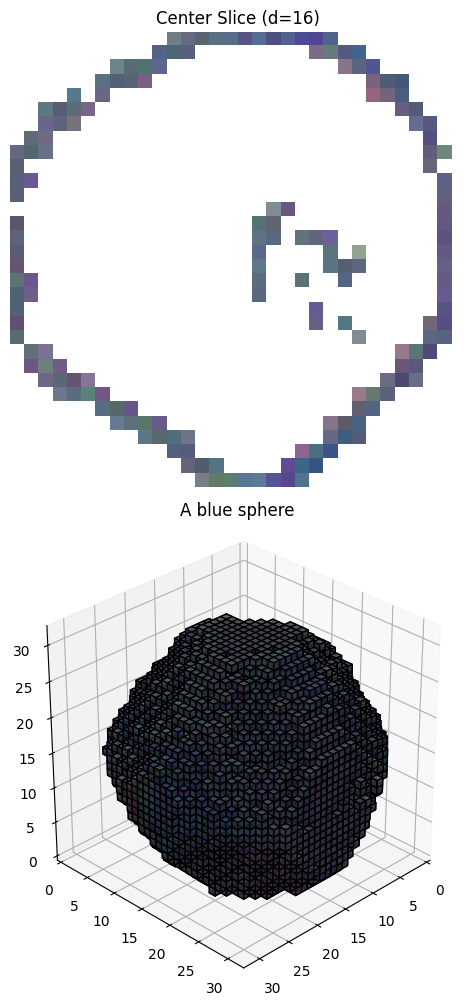

In [128]:
inferencer.visualize_samples(samples, prompt="A blue sphere", threshold=0.5, save_path="output/simple/blue_sphere_simple.png")

### Two stage

Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


Shape stage completed. Visualization:

Shape occupancy: 3002 voxels (9.16%)


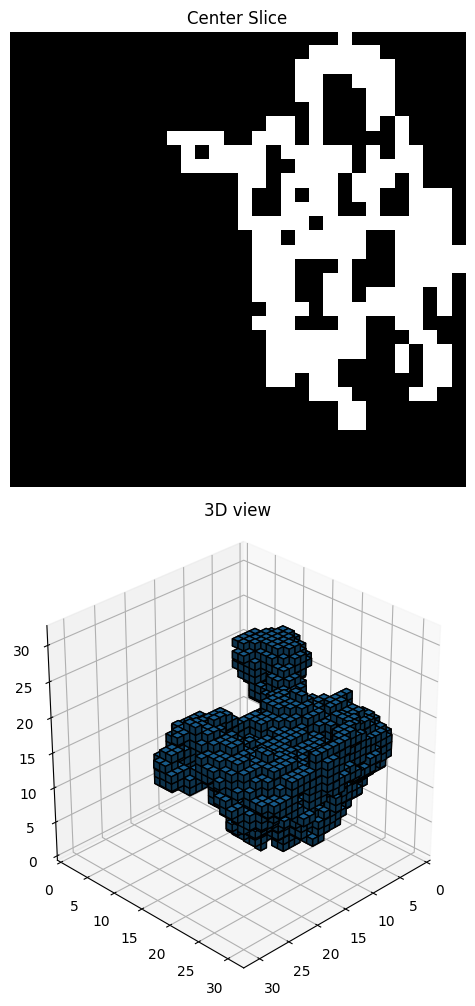


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]

In [121]:
samples = inferencer.sample_two_stage(
        prompt="A tree",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 3002 (9.16%)

Color Dominance:
Red: 44.1%
Green: 48.1%
Blue: 7.8%


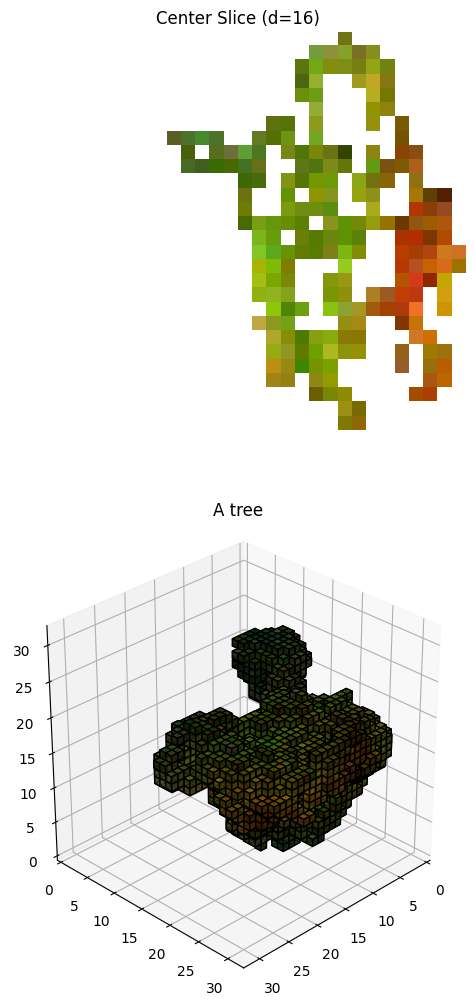

In [122]:
inferencer.visualize_samples(samples, prompt="A tree", threshold=0.5, save_path="output/two_stage/tree_two_stage.png")

In [ ]:
inferencer.visualize_samples_p3d(samples[0], threshold=0.5)

## Legolize


LEGO Bricks needed:
-----------------
2x4 brick: 9 pieces
2x1 brick: 63 pieces
1x4 brick: 38 pieces
1x1 brick: 46 pieces
1x2 brick: 16 pieces
2x3 brick: 3 pieces
2x2 brick: 18 pieces
1x3 brick: 11 pieces


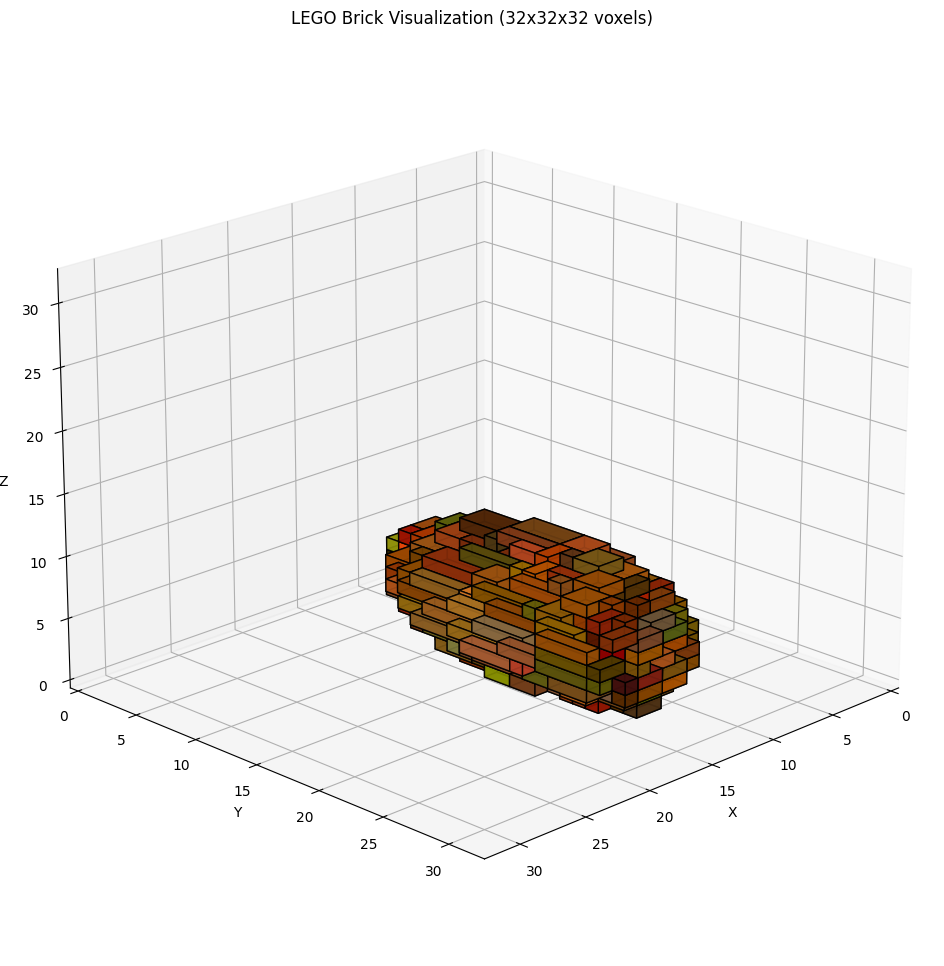


Total number of bricks: 204


In [54]:
converter = LegoConverter()
    
# Convert to LEGO bricks
lego_bricks = converter.convert_to_lego(samples[0])
    
# Create the visualization
converter.visualize_legolization(samples[0], lego_bricks, save_path="legolization_process.png")

# Get and print brick statistics
brick_stats = converter.get_brick_statistics(lego_bricks)
print("\nLEGO Bricks needed:")
print("-----------------")
for brick_name, count in brick_stats.items():
    print(f"{brick_name}: {count} pieces")

# Plot the 3D visualization
converter.plot_3d_bricks(lego_bricks)

print(f"\nTotal number of bricks: {len(lego_bricks)}")

## Diffusion process viz

Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


Shape stage completed. Visualization:

Shape occupancy: 9288 voxels (28.34%)


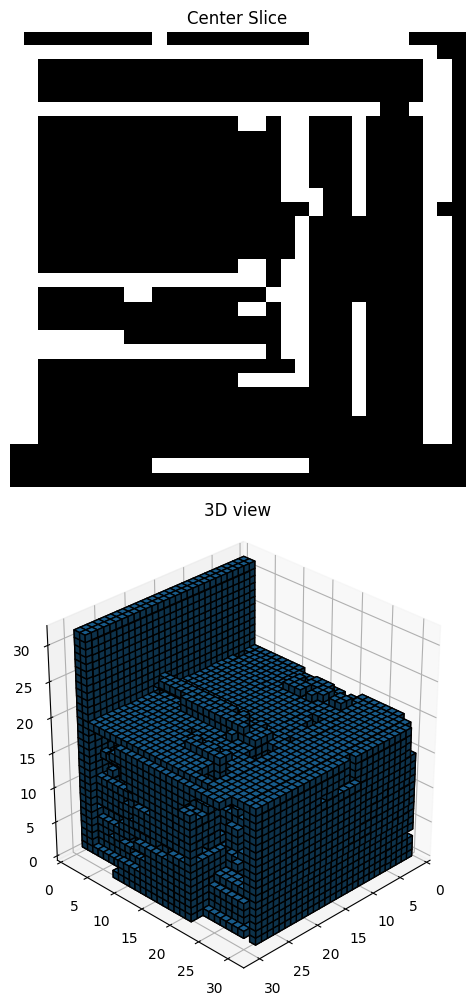


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]

In [9]:
steps_to_save = list(range(0, 1000, 100))  # Save every 100 steps
samples = inferencer.sample_two_stage(
    prompt="yellow pyramid",
    num_samples=1,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    save_diffusion_process=True,
    diffusion_steps_to_save=steps_to_save,
    show_after_shape=True,
    use_mean_init=False,
    use_rotations=False
    
)

## Evaluation

In [ ]:
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"  

# Run evaluation with different parameters
metrics = evaluate_generation(
    model=combined_model_combinedLoss,
    model_type='combined',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    use_rotations=False,
    device='cuda'
)

# Print results in a formatted way
print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")

In [12]:
# Get baseline for ablation
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

# For two-stage model
metrics = evaluate_generation(
    model=shape_model,
    color_model=color_model,  # Required for two_stage
    model_type='two_stage',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    use_rotations=False,
    device='cuda'
)

print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")

Evaluating 8 samples


Generating samples:   0%|                                 | 0/8 [00:00<?, ?it/s]


Current prompt: apple fruit, food red, round, shiny, fresh
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: sawyer fish marine life blue, yellow fins, striped
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: banana food yellow, curved
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: donut dessert, pastry pink, glazed, round, sweet
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: chef knife kitchenware, tools sharp, metallic, gray, stainless steel
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: military fighter jet aircraft, military vehicle gray, aerodynamic, sleek, modern
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: wooden chair furniture, seating brown, wooden, ladder back, traditional
Stage 1: Generating shapes...



Stage 2: Adding colors...



Current prompt: traffic cone safety equipment, road accessories orange, reflective, striped, conical
Stage 1: Generating shapes...



Stage 2: Adding colors...



Evaluation Results:
--------------------------------------------------
iou            : 0.0698
f1             : 0.1163
color_score    : 0.7685
combined_score : 0.4374


## Ablation study

### DDIM

In [13]:
# DDIM tests
ddim_steps = [200, 400]
ddim_results = {}

# Base configs remain the same but we'll create DDIM versions
shape_diffusion_config_ddim = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    use_ddim=True,  # Enable DDIM
    seed=42
)

color_diffusion_config_ddim = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    use_ddim=True,  # Enable DDIM
    seed=42
)

In [14]:
# Cell 2: Run evaluations for different DDIM steps
for num_steps in ddim_steps:
    print(f"\nEvaluating DDIM with {num_steps} steps...")
    
    # Load models with DDIM
    shape_model_ddim = load_model_for_inference(
        model_path="runs/experiment_two_stage/shape/models/final_model",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config_ddim,
        inference_steps=num_steps,
        device='cuda',
        ema=False
    )
    
    color_model_ddim = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/models/final_model",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config_ddim,
        inference_steps=num_steps,
        device='cuda',
        ema=False
    )
    
    # Evaluate
    metrics = evaluate_generation(
        model=shape_model_ddim,
        color_model=color_model_ddim,
        model_type='two_stage',
        test_data_dir=test_data_dir,
        annotation_file=annotation_file,
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        use_rotations=False,
        device='cuda'
    )
    
    ddim_results[num_steps] = metrics
    print(f"Results for {num_steps} steps:")
    for metric_name, value in metrics.items():
        print(f"{metric_name:15s}: {value:.4f}")


Evaluating DDIM with 200 steps...
The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
Set DDIM inference steps to 200
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights
Set DDIM inference steps to 200
Evaluating 8 samples


Generating samples:   0%|                                 | 0/8 [00:00<?, ?it/s]


Current prompt: apple fruit, food red, round, shiny, fresh
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.67it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.69it/s]
iou: 0.002 | f1: 0.003 | color_score: 0.308 | combined_score: 0.155:  12%|▏| 1/8


Current prompt: sawyer fish marine life blue, yellow fins, striped
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.69it/s]
iou: 0.000 | f1: 0.000:  25%|█████▎               | 2/8 [01:59<05:59, 59.90s/it]


Current prompt: banana food yellow, curved
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.69it/s]
iou: 0.016 | f1: 0.031 | color_score: 0.273 | combined_score: 0.148:  38%|▍| 3/8


Current prompt: donut dessert, pastry pink, glazed, round, sweet
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.67it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]
iou: 0.008 | f1: 0.015 | color_score: 0.311 | combined_score: 0.161:  50%|▌| 4/8


Current prompt: chef knife kitchenware, tools sharp, metallic, gray, stainless steel
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.67it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]
iou: 0.000 | f1: 0.000:  62%|█████████████▏       | 5/8 [04:59<02:59, 59.95s/it]


Current prompt: military fighter jet aircraft, military vehicle gray, aerodynamic, sleek, modern
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]
iou: 0.055 | f1: 0.105 | color_score: 0.453 | combined_score: 0.267:  75%|▊| 6/8


Current prompt: wooden chair furniture, seating brown, wooden, ladder back, traditional
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.67it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]
iou: 0.017 | f1: 0.033 | color_score: 0.335 | combined_score: 0.180:  88%|▉| 7/8


Current prompt: traffic cone safety equipment, road accessories orange, reflective, striped, conical
Stage 1: Generating shapes...












































































































































































































ampling Steps: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.67it/s]


Stage 2: Adding colors...











































































































































































































Color Sampling: 100%|█████████████████████████| 200/200 [00:29<00:00,  6.68it/s]

ou: 0.005 | f1: 0.010 | color_score: 0.328 | combined_score: 0.168: 100%|█| 8/8

Results for 200 steps:
iou            : 0.0127
f1             : 0.0246
color_score    : 0.3347
combined_score : 0.1798

Evaluating DDIM with 400 steps...
The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
Set DDIM inference steps to 400
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights
Set DDIM inference steps to 400
Evaluating 8 samples


Generating samples:   0%|                                 | 0/8 [00:00<?, ?it/s]


Current prompt: apple fruit, food red, round, shiny, fresh
Stage 1: Generating shapes...


























pling Steps:   6%|█▍                        | 23/400 [00:03<00:56,  6.63it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]



























































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.67it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]
iou: 0.000 | f1: 0.000:  12%|██▌                 | 1/8 [01:59<13:58, 119.85s/it]


Current prompt: sawyer fish marine life blue, yellow fins, striped
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]
iou: 0.001 | f1: 0.003 | color_score: 0.318 | combined_score: 0.160:  25%|▎| 2/8


Current prompt: banana food yellow, curved
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.69it/s]
iou: 0.004 | f1: 0.008 | color_score: 0.300 | combined_score: 0.153:  38%|▍| 3/8


Current prompt: donut dessert, pastry pink, glazed, round, sweet
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.67it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]
iou: 0.012 | f1: 0.024 | color_score: 0.283 | combined_score: 0.151:  50%|▌| 4/8


Current prompt: chef knife kitchenware, tools sharp, metallic, gray, stainless steel
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.67it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.68it/s]
iou: 0.003 | f1: 0.006 | color_score: 0.252 | combined_score: 0.128:  62%|▋| 5/8


Current prompt: military fighter jet aircraft, military vehicle gray, aerodynamic, sleek, modern
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [01:00<00:00,  6.66it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [01:00<00:00,  6.65it/s]
iou: 0.025 | f1: 0.048 | color_score: 0.383 | combined_score: 0.210:  75%|▊| 6/8


Current prompt: wooden chair furniture, seating brown, wooden, ladder back, traditional
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [01:00<00:00,  6.66it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.67it/s]
iou: 0.000 | f1: 0.000:  88%|█████████████████▌  | 7/8 [13:59<02:00, 120.02s/it]


Current prompt: traffic cone safety equipment, road accessories orange, reflective, striped, conical
Stage 1: Generating shapes...




















































































































































































































































































































































































































ampling Steps: 100%|█████████████████████████| 400/400 [01:00<00:00,  6.66it/s]


Stage 2: Adding colors...



















































































































































































































































































































































































































Color Sampling: 100%|█████████████████████████| 400/400 [01:00<00:00,  6.66it/s]
iou: 0.002 | f1: 0.003 | color_score: 0.267 | combined_score: 0.135: 100%|█| 8/8

Results for 400 steps:
iou            : 0.0059
f1             : 0.0116
color_score    : 0.3005
combined_score : 0.1561


In [37]:
# Visualizations for the ddim 

shape_model_ddim = load_model_for_inference(
        model_path="runs/experiment_two_stage/shape/models/final_model",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config_ddim,
        inference_steps=400,
        device='cuda',
        ema=False
    )
    
color_model_ddim = load_model_for_inference(
    model_path="runs/experiment_two_stage/color/models/final_model",
    voxel_config=color_voxel_config,
    diffusion_config=color_diffusion_config_ddim,
    inference_steps=400,
    device='cuda',
    ema=False)

The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
Set DDIM inference steps to 400
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights
Set DDIM inference steps to 400


In [38]:
inferencer = DiffusionInference3D(
        model=shape_model_ddim,
        noise_scheduler=shape_model_ddim.noise_scheduler,
        color_model=color_model_ddim,
        color_noise_scheduler=color_model_ddim.noise_scheduler,
        device='cuda'
    )

Stage 1: Generating shapes...



ampling Steps: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.71it/s]


Shape stage completed. Visualization:

Shape occupancy: 981 voxels (2.99%)


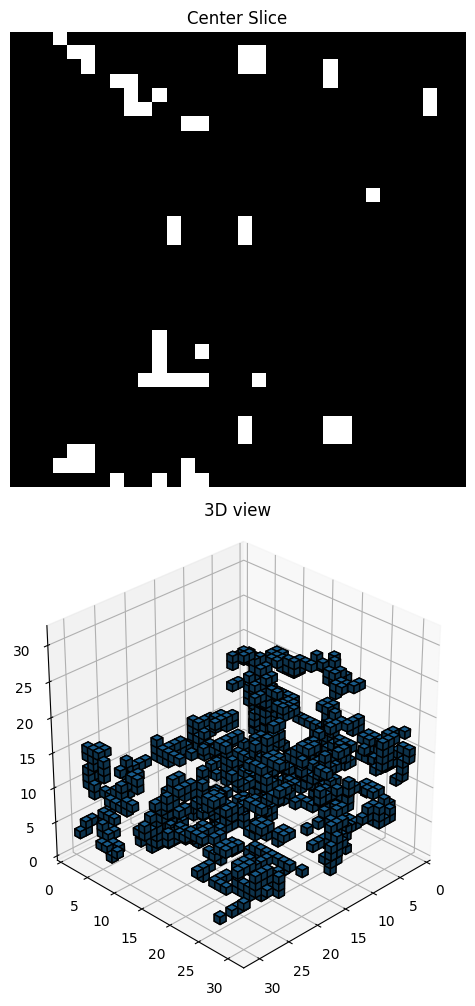


Stage 2: Adding colors...



olor Sampling: 100%|█████████████████████████| 400/400 [00:59<00:00,  6.69it/s]

In [39]:
samples = inferencer.sample_two_stage(
        prompt="a blue cube",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 981 (2.99%)

Color Dominance:
Red: 29.2%
Green: 69.6%
Blue: 1.3%


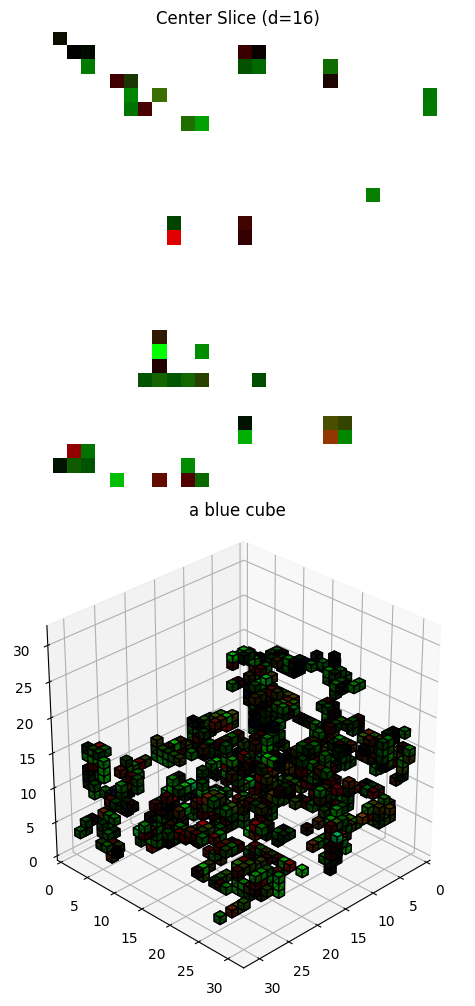

In [40]:
inferencer.visualize_samples(samples, prompt="a blue cube", threshold=0.5, save_path="output/ablation/blue_cube_ddim_400.png")

### Finetune vs Not Finetuned

In [9]:
shape_model = load_model_for_inference(
        model_path="runs/finetune/shape/models/model_step_135000",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=False
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/best_model/model",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=False
    )

The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights


In [ ]:
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

metrics = evaluate_generation(
    model=shape_model,
    color_model=color_model,
    model_type='two_stage',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    use_rotations=False,
    device='cuda'
)

print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")

In [10]:
# Visualizations

inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )

In [ ]:
samples = inferencer.sample_two_stage(
        prompt="a sword",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False,
        save_pipeline_viz=None
    )

In [ ]:
inferencer.visualize_samples(samples, prompt="a sword", threshold=0.5, save_path="output/ablation/sword_finetuned.png")

### Guidance scale

In [6]:
# Define guidance scale combinations to test
guidance_scales = {
    #'low': {'shape': 10.0, 'color': 10.0},
    #'baseline': {'shape': 20.0, 'color': 20.0}, already computed
    'high': {'shape': 30.0, 'color': 30.0},
    'higher': {'shape': 50.0, 'color': 50.0}
}

guidance_results = {}


In [33]:
# Load models (only need to do this once)
shape_model = load_model_for_inference(
    model_path="runs/experiment_two_stage/shape/models/final_model",
    voxel_config=shape_voxel_config,
    diffusion_config=shape_diffusion_config,
    device='cuda',
    ema=False
)

color_model = load_model_for_inference(
    model_path="runs/experiment_two_stage/color/models/final_model",
    voxel_config=color_voxel_config,
    diffusion_config=color_diffusion_config,
    device='cuda',
    ema=False
)


The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights


In [ ]:
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

# Run evaluations for different guidance scales
for scale_name, scale_values in guidance_scales.items():
    print(f"\nEvaluating guidance scale configuration: {scale_name}")
    print(f"Shape guidance: {scale_values['shape']}, Color guidance: {scale_values['color']}")
    
    # Evaluate
    metrics = evaluate_generation(
        model=shape_model,
        color_model=color_model,
        model_type='two_stage',
        test_data_dir=test_data_dir,
        annotation_file=annotation_file,
        guidance_scale=scale_values['shape'],
        color_guidance_scale=scale_values['color'],
        use_rotations=False,
        device='cuda'
    )
    
    guidance_results[scale_name] = metrics
    print(f"\nResults for {scale_name} guidance:")
    for metric_name, value in metrics.items():
        print(f"{metric_name:15s}: {value:.4f}")


Evaluating guidance scale configuration: high
Shape guidance: 30.0, Color guidance: 30.0
Evaluating 8 samples


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()




rent Averages | No metrics yet                    | 0/8 [00:00<?, ?it/s]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (1/8):  12%|██▎               | 1/8 [05:31<38:40, 331.43s/it] 0.572

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (2/8):  25%|████▌             | 2/8 [10:53<32:35, 325.97s/it] 0.413

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (3/8):  38%|██████▊           | 3/8 [16:18<27:07, 325.54s/it] 0.396

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (4/8):  50%|█████████         | 4/8 [21:37<21:31, 322.78s/it] 0.397

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (5/8):  62%|███████████▎      | 5/8 [27:03<16:11, 323.90s/it] 0.397

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (6/8):  75%|█████████████▌    | 6/8 [32:31<10:50, 325.50s/it] 0.416

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (7/8):  88%|███████████████▊  | 7/8 [37:59<05:26, 326.43s/it] 0.418

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (8/8): 100%|██████████████████| 8/8 [43:30<00:00, 326.37s/it] 0.405

urrent Averages | iou: 0.080 | f1: 0.135 | color_score: 0.686 | combined_score: 0.405




Final Results:
iou: 0.0801
f1: 0.1353
color_score: 0.6862
combined_score: 0.4046

Results for high guidance:
iou            : 0.0801
f1             : 0.1353
color_score    : 0.6862
combined_score : 0.4046

Evaluating guidance scale configuration: higher
Shape guidance: 50.0, Color guidance: 50.0
Evaluating 8 samples






rent Averages | No metrics yet                    | 0/8 [00:00<?, ?it/s]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (1/8):  12%|██▎               | 1/8 [05:39<39:35, 339.41s/it] 0.478

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (2/8):  25%|████▌             | 2/8 [11:08<33:19, 333.29s/it] 0.347

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (3/8):  38%|██████▊           | 3/8 [16:24<27:06, 325.32s/it] 0.347

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (4/8):  50%|█████████         | 4/8 [21:49<21:41, 325.27s/it] 0.343

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing samples (5/8):  62%|███████████▎      | 5/8 [27:17<16:19, 326.34s/it] 0.343

Stage 1: Generating shapes...


In [51]:
# Visualizations

inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )


Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


Shape stage completed. Visualization:

Shape occupancy: 3820 voxels (11.66%)


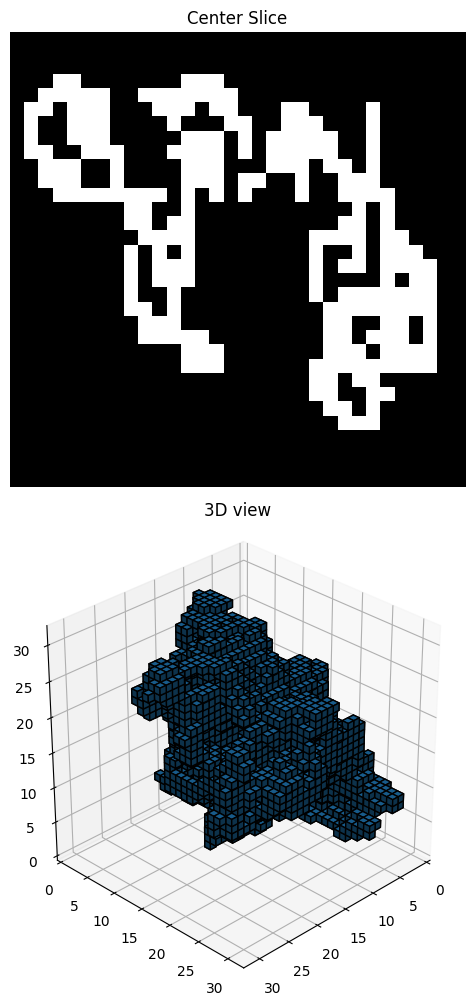


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]

In [53]:
samples = inferencer.sample_two_stage(
        prompt="Grey dog jumping on his owner",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 3820 (11.66%)

Color Dominance:
Red: 36.8%
Green: 32.0%
Blue: 31.2%


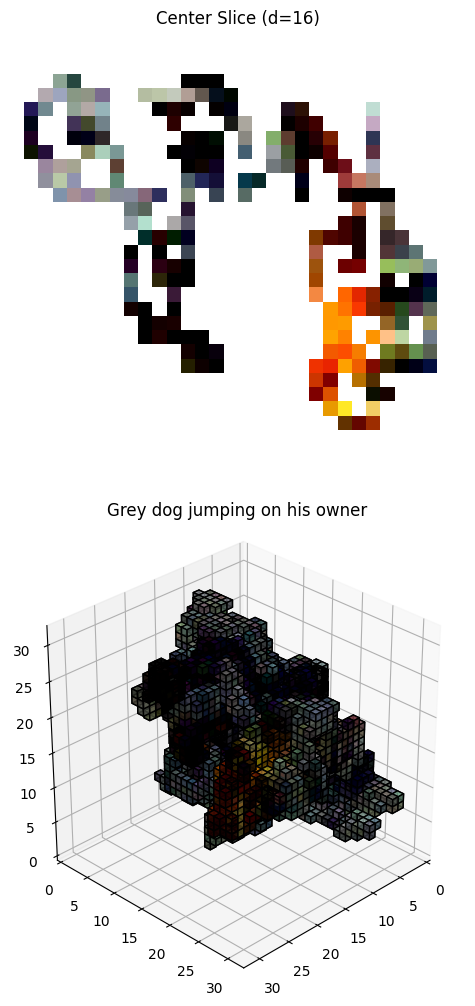

In [54]:
inferencer.visualize_samples(samples, prompt="Grey dog jumping on his owner", threshold=0.5, save_path="last.png")

### Mean initialization vs No Mean initialization

In [18]:
shape_model = load_model_for_inference(
    model_path="runs/experiment_two_stage/shape/models/final_model",
    voxel_config=shape_voxel_config,
    diffusion_config=shape_diffusion_config,
    device='cuda',
    ema=False
)

color_model = load_model_for_inference(
    model_path="runs/experiment_two_stage/color/models/final_model",
    voxel_config=color_voxel_config,
    diffusion_config=color_diffusion_config,
    device='cuda',
    ema=False
)


The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights


In [16]:
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

metrics = evaluate_generation(
    model=shape_model,
    color_model=color_model,
    model_type='two_stage',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    use_rotations=False,
    use_mean_init=True,
    device='cuda'
)

print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")


Starting evaluation of 8 samples...
Model type: two_stage
Guidance scale: 20.0, Color guidance: 20.0
--------------------------------------------------



rics | Waiting for first sample...                                        | 0/8 [00:00<?, ?it/s]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (1/8):  12%|█████▊                                        | 1/8 [05:22<37:35, 322.22s/it]


Sample 1/8 - red_apple_001
Prompt: apple fruit, food red, round, shiny, fresh
Metrics:
  iou            : 0.3501
  f1             : 0.5186
  color_score    : 0.8271
  combined_score : 0.6307
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (2/8):  25%|███████████▌                                  | 2/8 [10:44<32:12, 322.03s/it]


Sample 2/8 - sawyer_fish_001
Prompt: sawyer fish marine life blue, yellow fins, striped
Metrics:
  iou            : 0.0256
  f1             : 0.0498
  color_score    : 0.7497
  combined_score : 0.3937
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (3/8):  38%|█████████████████▎                            | 3/8 [16:02<26:42, 320.53s/it]


Sample 3/8 - banana_001
Prompt: banana food yellow, curved
Metrics:
  iou            : 0.0000
  f1             : 0.0000
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (4/8):  50%|███████████████████████                       | 4/8 [21:19<21:15, 318.85s/it]


Sample 4/8 - donut_001
Prompt: donut dessert, pastry pink, glazed, round, sweet
Metrics:
  iou            : 0.0431
  f1             : 0.0827
  color_score    : 0.7260
  combined_score : 0.3944
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (5/8):  62%|████████████████████████████▊                 | 5/8 [26:26<15:44, 314.84s/it]


Sample 5/8 - kitchen_knife_001
Prompt: chef knife kitchenware, tools sharp, metallic, gray, stainless steel
Metrics:
  iou            : 0.0000
  f1             : 0.0000
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (6/8):  75%|██████████████████████████████████▌           | 6/8 [31:37<10:26, 313.46s/it]


Sample 6/8 - fighter_jet_001
Prompt: military fighter jet aircraft, military vehicle gray, aerodynamic, sleek, modern
Metrics:
  iou            : 0.0000
  f1             : 0.0000
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (7/8):  88%|████████████████████████████████████████▎     | 7/8 [36:47<05:12, 312.36s/it]


Sample 7/8 - wooden_chair_001
Prompt: wooden chair furniture, seating brown, wooden, ladder back, traditional
Metrics:
  iou            : 0.0108
  f1             : 0.0215
  color_score    : 0.8337
  combined_score : 0.4249
--------------------------------------------------
Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (8/8): 100%|██████████████████████████████████████████████| 8/8 [42:00<00:00, 315.02s/it]
Running Averages | iou: 0.0661 | f1: 0.1066 | color_score: 0.7746 | combined_score: 0.4563


Sample 8/8 - traffic_cone_001
Prompt: traffic cone safety equipment, road accessories orange, reflective, striped, conical
Metrics:
  iou            : 0.0990
  f1             : 0.1801
  color_score    : 0.7362
  combined_score : 0.4379
--------------------------------------------------


Final Results:
--------------------
iou            : 0.0661
f1             : 0.1066
color_score    : 0.7746
combined_score : 0.4563

Evaluation Results:
--------------------------------------------------
iou            : 0.0661
f1             : 0.1066
color_score    : 0.7746
combined_score : 0.4563


In [19]:
# Visualizations

inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )



Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████████| 1000/1000 [02:29<00:00,  6.68it/s]


Shape stage completed. Visualization:

Shape occupancy: 360 voxels (1.10%)


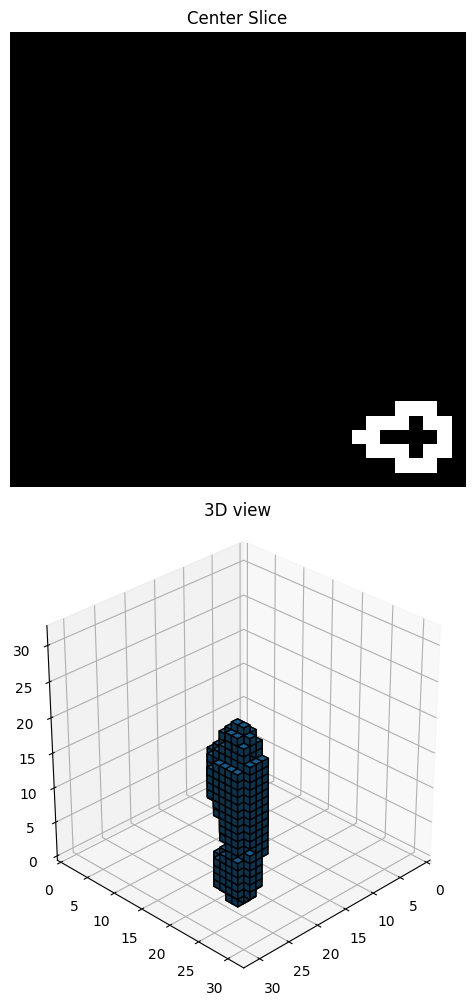


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████████| 1000/1000 [02:30<00:00,  6.65it/s]

In [20]:
samples = inferencer.sample_two_stage(
        prompt="a banana",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=True,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 360 (1.10%)

Color Dominance:
Red: 63.7%
Green: 32.6%
Blue: 3.7%


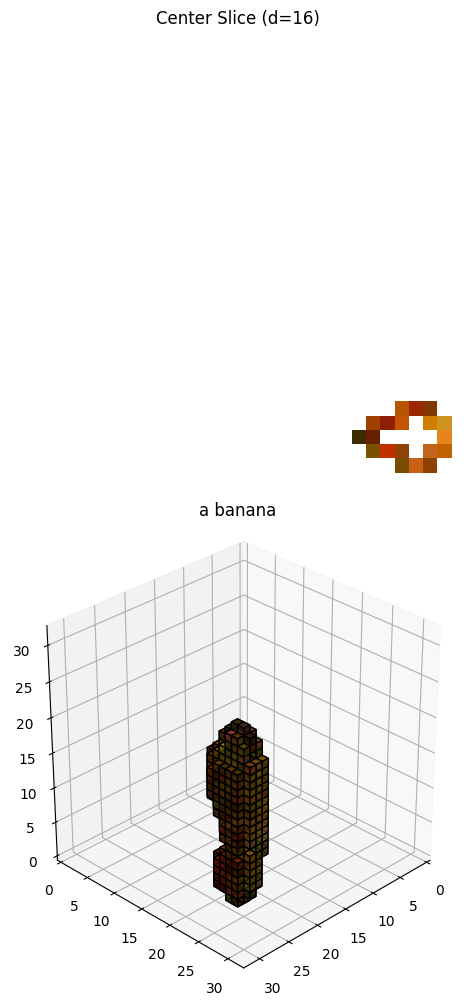

In [21]:
inferencer.visualize_samples(samples, prompt="a banana", threshold=0.5, save_path="output/ablation/banana_mininit.png")

### EMA vs No EMA

In [18]:
shape_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/shape/best_model/model",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=True
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/best_model/model",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=True
    )

The number of input channels is: 1 The number of out channels is1


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 120000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120096449
Loaded EMA model weights
The number of input channels is: 4 The number of out channels is3


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 110000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120099331
Loaded EMA model weights


In [14]:
# Get baseline for ablation
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

# For two-stage model
metrics = evaluate_generation(
    model=shape_model,
    color_model=color_model,  # Required for two_stage
    model_type='two_stage',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    use_rotations=False,
    device='cuda'
)

print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")

Evaluating 8 samples


Evaluating samples:   0%|                                 | 0/8 [00:00<?, ?it/s]


Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  12%|███                     | 1/8 [04:58<34:49, 298.48s/it] 0.537

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  25%|██████                  | 2/8 [09:56<29:50, 298.43s/it] 0.537

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  38%|█████████               | 3/8 [14:55<24:51, 298.34s/it] 0.537

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  50%|████████████            | 4/8 [19:53<19:53, 298.35s/it] 0.476

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  62%|███████████████         | 5/8 [24:52<14:55, 298.47s/it] 0.476

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  75%|██████████████████      | 6/8 [29:50<09:57, 298.54s/it] 0.491

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples:  88%|█████████████████████   | 7/8 [34:49<04:58, 298.56s/it] 0.491

Stage 1: Generating shapes...

Stage 2: Adding colors...



Evaluating samples: 100%|████████████████████████| 8/8 [39:48<00:00, 298.51s/it] 0.491
Current Averages | iou: 0.039 | f1: 0.070 | color_score: 0.836 | combined_score: 0.491


Evaluation Results:
--------------------------------------------------
iou            : 0.0394
f1             : 0.0701
color_score    : 0.8358
combined_score : 0.4909


In [19]:
# Visualizations

inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )


Stage 1: Generating shapes...


Sampling Steps: 100%|███████████████████████| 1000/1000 [02:30<00:00,  6.64it/s]



Shape stage completed. Visualization:

Shape occupancy: 2344 voxels (7.15%)


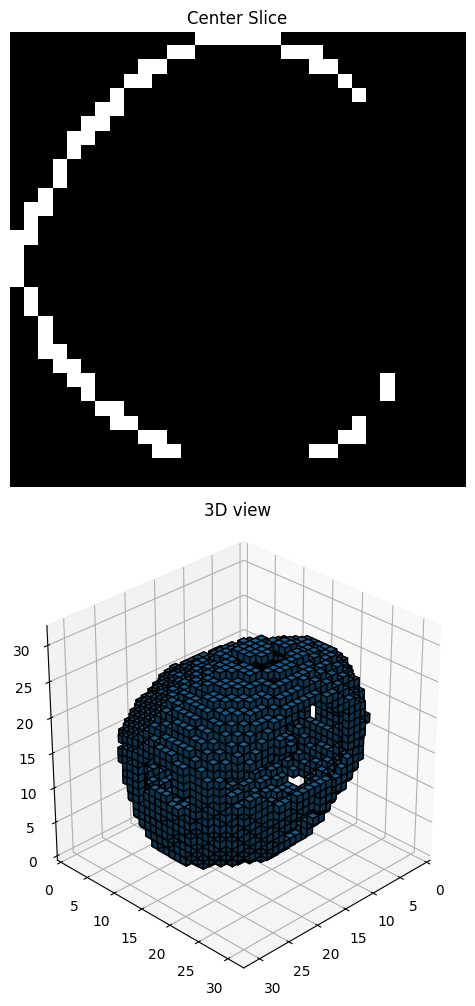


Stage 2: Adding colors...


Color Sampling: 100%|███████████████████████| 1000/1000 [02:30<00:00,  6.64it/s]


In [20]:
samples = inferencer.sample_two_stage(
        prompt="a basketball",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 2344 (7.15%)

Color Dominance:
Red: 56.7%
Green: 32.5%
Blue: 10.8%


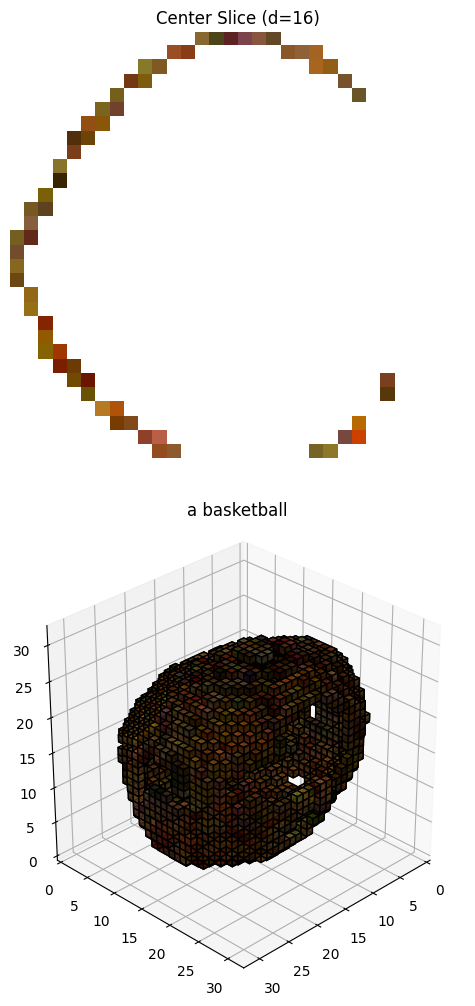

In [21]:
inferencer.visualize_samples(samples, prompt="a basketball", threshold=0.5, save_path="output/ablation/basketball_ema.png")

### rotation-augmented sampling vs no rotation augmented sampling

In [23]:
shape_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/shape/best_model/model",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=False
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/best_model/model",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=False
    )

The number of input channels is: 1 The number of out channels is1
Total parameters: 120096449
Loaded main model weights
The number of input channels is: 4 The number of out channels is3
Total parameters: 120099331
Loaded main model weights


In [17]:
# Get baseline for ablation
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"

# For two-stage model
metrics = evaluate_generation(
    model=shape_model,
    color_model=color_model,  # Required for two_stage
    model_type='two_stage',
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    guidance_scale=20.0,
    color_guidance_scale=20.0,
    use_rotations=True,
    use_mean_init=False,
    device='cuda'
)

print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")


Starting evaluation of 8 samples...
Model type: two_stage
Guidance scale: 20.0, Color guidance: 20.0
--------------------------------------------------


Overall Progress:   0%|                                                       | 0/8 [00:00<?, ?it/s]
rics | Waiting for first sample...

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (1/8):  12%|█████▌                                      | 1/8 [14:51<1:44:01, 891.60s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (2/8):  25%|███████████                                 | 2/8 [29:42<1:29:08, 891.48s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (3/8):  38%|████████████████▌                           | 3/8 [44:34<1:14:16, 891.29s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (4/8):  50%|███████████████████████                       | 4/8 [59:26<59:26, 891.62s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (5/8):  62%|███████████████████████████▌                | 5/8 [1:14:19<44:36, 892.29s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (6/8):  75%|█████████████████████████████████           | 6/8 [1:29:13<29:45, 892.76s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (7/8):  88%|██████████████████████████████████████▌     | 7/8 [1:44:06<14:52, 892.97s/it]

Stage 1: Generating shapes...

Stage 2: Adding colors...



Processing (8/8): 100%|████████████████████████████████████████████| 8/8 [1:59:00<00:00, 892.53s/it]
Running Averages | iou: 0.0589 | f1: 0.0970 | color_score: 0.8430 | combined_score: 0.4839



Final Results:
--------------------
iou            : 0.0589
f1             : 0.0970
color_score    : 0.8430
combined_score : 0.4839

Evaluation Results:
--------------------------------------------------
iou            : 0.0589
f1             : 0.0970
color_score    : 0.8430
combined_score : 0.4839


In [24]:
# Visualizations

inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )


Stage 1: Generating shapes...


Sampling Steps: 100%|███████████████████████| 1000/1000 [07:25<00:00,  2.24it/s]



Shape stage completed. Visualization:

Shape occupancy: 2303 voxels (7.03%)


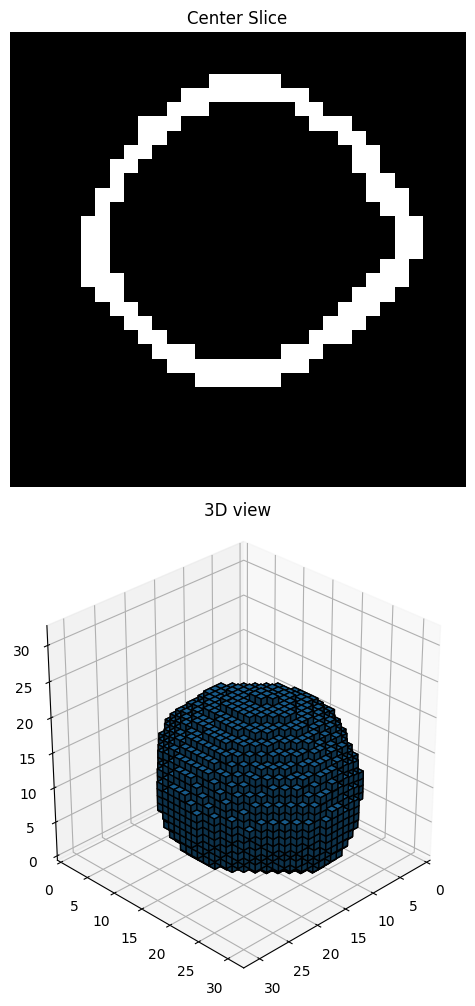


Stage 2: Adding colors...


Color Sampling: 100%|███████████████████████| 1000/1000 [07:24<00:00,  2.25it/s]


In [26]:
samples = inferencer.sample_two_stage(
        prompt="a banana",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=20.0,
        color_guidance_scale=20.0,
        show_after_shape=True,
        use_rotations=True, 
        use_mean_init=False,
        save_pipeline_viz=None
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 2303 (7.03%)

Color Dominance:
Red: 54.1%
Green: 45.7%
Blue: 0.2%


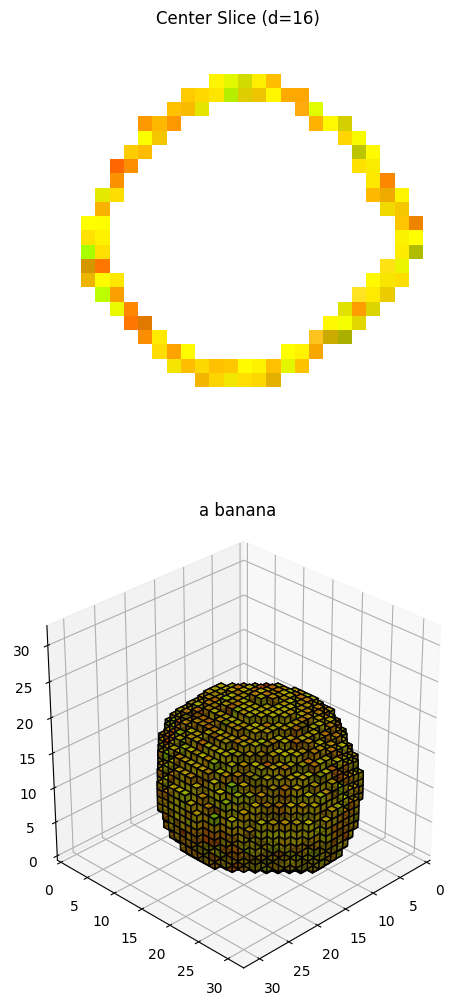

In [27]:
inferencer.visualize_samples(samples, prompt="a banana", threshold=0.5, save_path="output/ablation/banana_rot_aug.png")